# XEB Benchmark

In [15]:
import dynex
from dynex import dynex_circuit
import pennylane as qml
from pennylane import numpy as np
import random, statistics
import matplotlib.pyplot as plt
import json
import math

In [17]:
sycamore_matrix = np.array([
    [1, 0,   0,           0],
    [0, 0,   -1j,          0],
    [0, -1j,  0,           0],
    [0, 0,   0, np.exp(-1j*np.pi/6)]
], dtype=complex)

def sycamore(wires):
    qml.QubitUnitary(sycamore_matrix, wires=wires)

def apply_single_qubit_operation(p, wire):
    qml.RZ(p*np.pi, wires=wire)
    qml.RX(np.pi/2, wires=wire)
    qml.RZ(-p*np.pi, wires=wire)

def pattern_type(cycle):
    mod8 = cycle % 8
    if mod8 == 0:
        return 'A'
    elif mod8 == 1:
        return 'B'
    elif mod8 == 2:
        return 'C'
    elif mod8 == 3:
        return 'D'
    elif mod8 == 4:
        return 'C'
    elif mod8 == 5:
        return 'D'
    elif mod8 == 6:
        return 'A'
    elif mod8 == 7:
        return 'B'

In [18]:
def get_two_qubit_pairs(ptype, qbs, rows, cols):
    qubit_map = {(q[0], q[1]): i for i,q in enumerate(qbs)}
    pairs = []
    if ptype == 'A':
        for x in range(rows):
            if x % 2 == 0:
                for y in range(cols - 1):
                    if (x,y) in qubit_map and (x,y+1) in qubit_map:
                        pairs.append((qubit_map[(x,y)], qubit_map[(x,y+1)]))
    elif ptype == 'B':
        for y in range(cols):
            if y % 2 == 0:
                for x in range(rows - 1):
                    if (x,y) in qubit_map and (x+1,y) in qubit_map:
                        pairs.append((qubit_map[(x,y)], qubit_map[(x+1,y)]))
    elif ptype == 'C':
        for x in range(rows):
            if x % 2 == 1:
                for y in range(cols - 1):
                    if (x,y) in qubit_map and (x,y+1) in qubit_map:
                        pairs.append((qubit_map[(x,y)], qubit_map[(x,y+1)]))
    elif ptype == 'D':
        for y in range(cols):
            if y % 2 == 1:
                for x in range(rows - 1):
                    if (x,y) in qubit_map and (x+1,y) in qubit_map:
                        pairs.append((qubit_map[(x,y)], qubit_map[(x+1,y)]))
    return pairs

In [19]:
def compute_linear_xeb(freqs, probs):
    total = sum(freqs.values())
    xeb_sum = 0.0
    for s_int, count in freqs.items():
        p_ideal = probs[s_int]
        xeb_sum += ((len(probs)*p_ideal) - 1) * (count / total)
    return xeb_sum

In [20]:
def patch_xeb_fidelity(ops, qbs, freqs, patch_qubits):
    # Re-map patch_qubits to [0,...,patch_size-1]
    patch_size = len(patch_qubits)
    patch_qmap = {q:i for i,q in enumerate(patch_qubits)}

    # Extract patch ops for the chosen subset of qubits:
    patch_ops = []
    q_map = {q:i for i,q in enumerate(qbs)}
    for op in ops:
        op_wires = op["wires"]
        # Check if all wires in op_wires are in patch_qubits
        if all(qbs[w] in patch_qubits for w in op_wires):
            # remap wires to patch indexing
            new_wires = [patch_qmap[qbs[w]] for w in op_wires]
            patch_ops.append({"type":op["type"], "params":op.get("params", None), "wires":new_wires})

    # Device for patch simulation
    dev_patch = qml.device("default.qubit", wires=patch_size, shots=None)

    @qml.qnode(dev_patch)
    def patch_qnode():
        for op in patch_ops:
            if op["type"] == "1q":
                p, w = op["params"], op["wires"][0]
                apply_single_qubit_operation(p, w)
            else:
                sycamore(op["wires"])
        return qml.state()

    patch_state = patch_qnode()
    patch_probs = np.abs(patch_state)**2

    # Now extract patch frequencies:
    # For each measured bitstring of the full device, we only keep bits corresponding to patch qubits.
    # patch_indices is replaced by patch_qmap usage
    # We know patch_probs length = 2^(patch_size)
    # s_int for patch is formed by bits from patch qubits extracted from bs_int
    # q_map is no longer needed for indexing since we have patch_qmap
    full_q_map = {q:i for i,q in enumerate(qbs)}
    # For each frequency key bs_int (int), we need to extract bits from patch qubits.
    patch_freqs = {}
    for bs_int, count in freqs.items():
        patch_val = 0
        # Extract bits corresponding to patch_qubits:
        # For each patch wire (original q), get its index in full qbs,
        # extract that bit from bs_int, place it in patch_val
        for i, q_ in enumerate(patch_qubits):
            full_qi = full_q_map[q_]
            bit = (bs_int >> full_qi) & 1
            patch_val |= (bit << i)
        patch_freqs[patch_val] = patch_freqs.get(patch_val, 0) + count

    return float(compute_linear_xeb(patch_freqs, patch_probs))

In [21]:
def circuit_ops(depth):
    ops = []
    random_choices = []
    for d in range(depth):
        gate_p = [random.choice(p_values) for _ in qbs]
        random_choices.append(gate_p)

    # Continue with original operation building
    for d in range(depth):
        for i, q_ in enumerate(qbs):
            p = random_choices[d][i]
            ops.append({"type":"1q", "params":p, "wires":[i]})
        ptype = pattern_type(d)
        pairs = get_two_qubit_pairs(ptype, qbs, rows, cols)
        for (w1, w2) in pairs:
            ops.append({"type":"2q", "wires":[w1,w2]})
    return ops

def estimate_flops(n_qubits, depth):
    """
    Estimate the FLOPs required to compute a single amplitude.
    This is a rough estimate inspired by published scaling results.
    The formula is not official and is only for illustrative purposes.
    """
    # Example heuristic:
    # ln(FLOPs) ≈ 0.7634 * n_qubits + 0.1297 * depth
    log_flops = 0.7634 * n_qubits + 0.1297 * depth
    return np.exp(log_flops)

def estimate_time_years(flops_for_one_amplitude):
    """
    Estimate how many years it would take on a Frontier-like supercomputer.
    
    Assumptions:
    - Frontier peak: ~1.7e18 FLOPs/s (single precision)
    - Efficiency: 20% effective FLOPs
    - We want to generate 1 million samples, each requiring ~10 amplitudes:
      total amplitudes ~10 million = 1e7 amplitudes
    """
    effective_FLOPs_per_s = 1.7e18 * 0.2  # 20% efficiency
    total_flops_needed = flops_for_one_amplitude * 1e7
    time_seconds = total_flops_needed / effective_FLOPs_per_s
    return time_seconds / (3600 * 24 * 365)

def define_patches():
    """Define 8 non-overlapping 5x2 patches for a 10x10 grid"""
    patches = []
    # First row of patches (from left to right)
    patches.append([(r,c) for r in range(5) for c in range(2)])      # Patch 0: (0-4, 0-1)
    patches.append([(r,c) for r in range(5) for c in range(2,4)])    # Patch 1: (0-4, 2-3)
    patches.append([(r,c) for r in range(5) for c in range(4,6)])    # Patch 2: (0-4, 4-5)
    patches.append([(r,c) for r in range(5) for c in range(6,8)])    # Patch 3: (0-4, 6-7)
    patches.append([(r,c) for r in range(5) for c in range(8,10)])   # Patch 4: (0-4, 8-9)
    
    # Second row of patches (from left to right)
    patches.append([(r,c) for r in range(5,10) for c in range(2)])   # Patch 5: (5-9, 0-1)
    patches.append([(r,c) for r in range(5,10) for c in range(2,4)]) # Patch 6: (5-9, 2-3)
    patches.append([(r,c) for r in range(5,10) for c in range(4,6)]) # Patch 7: (5-9, 4-5)
    patches.append([(r,c) for r in range(5,10) for c in range(6,8)]) # Patch 8: (5-9, 6-7)
    patches.append([(r,c) for r in range(5,10) for c in range(8,10)])# Patch 9: (5-9, 8-9)
    
    return patches

In [30]:
random.seed(42)
rows, cols = 10,10
p_values = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75]

# Reduced parameters for testing
depths_to_test = [5, 25, 125, 200]
n_instances_per_depth = 5

qbs = [(r,c) for r in range(rows) for c in range(cols)]
n_qubits = len(qbs)

# Define patches
patches = define_patches()

def create_circuit(ops, n_qubits):
    def circuit(params):
        for op in ops:
            if op["type"] == "1q":
                p, w = op["params"], op["wires"][0]
                apply_single_qubit_operation(p, w)
            else:
                sycamore(op["wires"])
        return qml.state()
    return circuit

patch_products = []
all_measurements = []  # Store all measurements

In [31]:
for depth in depths_to_test:
    flops = estimate_flops(n_qubits, depth)
    years = estimate_time_years(flops)
    print(f"\nDepth {depth}:")
    print(f"Estimated FLOPs per amplitude: {flops:.2e}")
    print(f"Estimated classical simulation time: {years:.2e} years")
    
    instance_vals = []
    depth_measurements = []  # Store measurements for this depth
    
    for instance in range(n_instances_per_depth):
        print(f"Processing depth {depth}, instance {instance+1}/{n_instances_per_depth}")
        
        # Generate circuit operations
        ops = circuit_ops(depth)
        
        # Create and execute circuit using Dynex
        circuit_to_execute = create_circuit(ops, n_qubits)
        
        try:
            # Execute the circuit on Dynex
            samples = dynex_circuit.execute(
                circuit_to_execute, 
                params=[],  # Empty params list but required
                wires=n_qubits,
                mainnet=True,
                method='all',
                is_cluster=True,
                cluster_type=0,
                num_reads=100,  
                shots=256,
                integration_steps=100,
                logging=True
            )
            print('Measure:', samples)
            # Print sample information
            freqs = {}
            if isinstance(samples, np.ndarray):
                # Handle single sample case
                val = 0
                for i, bit in enumerate(samples.flatten()):  # Flatten the array if needed
                    val |= (int(bit) << i)
                freqs[val] = 1
            else:
                # Handle multiple samples case
                for sample in samples:
                    val = 0
                    for i, bit in enumerate(sample):
                        val |= (int(bit) << i)
                    freqs[val] = freqs.get(val, 0) + 1

            # Store measurement results
            depth_measurements.append({
                'instance': instance,
                'samples': samples.tolist() if isinstance(samples, np.ndarray) else samples,
                'frequencies': freqs
            })

            # Calculate patch fidelities
            patch_fidelities = []
            for patch in patches:
                f_patch = float(patch_xeb_fidelity(ops, qbs, freqs, patch))
                patch_fidelities.append(f_patch)
            
            # Calculate geometric mean of patch fidelities
            patch_product = float(np.exp(np.mean(np.log(np.abs(patch_fidelities)))))
            instance_vals.append(patch_product)

        except Exception as e:
            print(f"Error in execution: {str(e)}")
            continue

    if instance_vals:
        avg_patch = statistics.mean(instance_vals)
        patch_products.append((depth, avg_patch))
        print(f"Depth={depth}: Avg Patch Product Fidelity={avg_patch:.8f}")
        
        # Store all measurements for this depth
        all_measurements.append({
            'depth': depth,
            'measurements': depth_measurements,
            'avg_fidelity': avg_patch
        })

in_atomics {'data': [{'worker_id': '004d25d3-2c82-59e0-8a53-c536db5e5d67', 'chips': 100, 'steps': 0, 'loc': 0, 'energy': 0, 'version': '2.3.5.OZM.134.L.N1F06', 'updated_at': '2024-12-18T12:29:25.271492Z', 'update_dur': '2.629190174s', 'uptime_dur': '2.73241774s'}, {'worker_id': '007181d0-cd64-54fc-b0b7-9ad2349252b4', 'chips': 100, 'steps': 0, 'loc': 0, 'energy': 0, 'version': '2.3.5.OZM.134.L.N1F06', 'updated_at': '2024-12-18T12:28:52.352445Z', 'update_dur': '35.548239193s', 'uptime_dur': '35.669396459s'}, {'worker_id': '0b85e7ea-2771-5783-b33f-5678edfd3a54', 'chips': 100, 'steps': 0, 'loc': 0, 'energy': 0, 'version': '2.3.5.OZM.134.L.N1F06', 'updated_at': '2024-12-18T12:28:54.754985Z', 'update_dur': '33.145699874s', 'uptime_dur': '33.244594034s'}, {'worker_id': '1029ae2e-346a-5c1a-aa62-184883ac5df9', 'chips': 100, 'steps': 0, 'loc': 0, 'energy': 0, 'version': '2.3.5.OZM.134.L.N1F06', 'updated_at': '2024-12-18T12:28:24.71806Z', 'update_dur': '1m3.182625334s', 'uptime_dur': '1m3.2841226

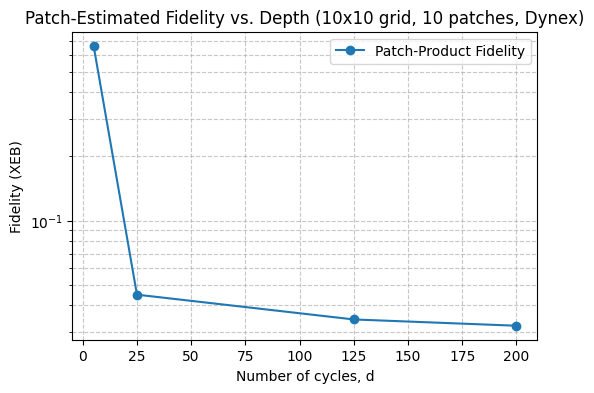

All measurements have been saved to 'all_measurements.txt'


In [32]:
# Plot results if we have data
if patch_products:
    depths = [d for d,_ in patch_products]
    vals = [v for _,v in patch_products]

    plt.figure(figsize=(6,4))
    plt.semilogy(depths, vals, 'o-', label='Patch-Product Fidelity')
    plt.xlabel("Number of cycles, d")
    plt.ylabel("Fidelity (XEB)")
    plt.title("Patch-Estimated Fidelity vs. Depth (10x10 grid, 10 patches, Dynex)")
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend()
    plt.savefig('dynex_xeb_results.png')
    plt.show()

# Save all measurements to a JSON file
    with open('all_measurements.txt', 'w') as f:
        print(all_measurements, file=f)
    print("All measurements have been saved to 'all_measurements.txt'")
else:
    print("No data collected to plot")()